In [2]:
import os
import sys
import torch
import pandas as pd
from tqdm import tqdm

PROJECT_ROOT = os.path.abspath(os.path.join(".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


In [9]:
import torch
from src.model import get_resnet18_feature_extractor
from src.image_utils import load_image

model = get_resnet18_feature_extractor()

sample_image_path = "../notebooks/images/raw/" + os.listdir("../notebooks/images/raw")[0]

img_tensor = load_image(sample_image_path)
img_tensor = img_tensor.unsqueeze(0)  # batch dimension

with torch.no_grad():
    embedding = model(img_tensor)

print("Embedding shape:", embedding.shape)


e:\Project 2026\satellite-property-valuation\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Project 2026\satellite-property-valuation\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Embedding shape: torch.Size([1, 512, 1, 1])


In [10]:
embedding_flat = embedding.view(embedding.size(0), -1)
print("Flattened shape:", embedding_flat.shape)


Flattened shape: torch.Size([1, 512])


In [11]:
from src.model import get_resnet18_feature_extractor
from src.image_utils import load_image

model = get_resnet18_feature_extractor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Using device:", device)


Using device: cpu


In [12]:
IMAGE_DIR = "../notebooks/images/raw"

image_files = os.listdir(IMAGE_DIR)
image_files = image_files[:15209]   # safety

print("Total images used:", len(image_files))


Total images used: 15093


In [13]:
embeddings = []
image_ids = []

for img_file in tqdm(image_files):
    img_path = os.path.join(IMAGE_DIR, img_file)

    img_tensor = load_image(img_path).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model(img_tensor)
        emb = emb.view(emb.size(0), -1)  # flatten

    embeddings.append(emb.cpu().numpy()[0])
    image_ids.append(int(img_file.replace(".png", "")))


100%|██████████| 15093/15093 [07:51<00:00, 32.00it/s]


In [15]:
embedding_df = pd.DataFrame(
    embeddings,
    index=image_ids
)

embedding_df.index.name = "id"

print(embedding_df.shape)


(15093, 512)


In [17]:
train_df = pd.read_csv("../data/raw/train.csv")
test_df  = pd.read_csv("../data/raw/test.csv")

In [19]:
sample_tabular = train_df[train_df["id"].isin(image_ids)]

merged_df = sample_tabular.merge(
    embedding_df,
    left_on="id",
    right_index=True
)

print("shape:", merged_df.shape)
merged_df.head()


shape: (15191, 533)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,502,503,504,505,506,507,508,509,510,511
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,0.008216,0.219998,0.139626,0.966497,0.000000,1.772746,0.714141,0.501754,0.798764,0.009357
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,0.258638,1.019978,0.125393,0.039756,0.047699,1.424471,0.993477,1.795510,0.527857,0.074465
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,1.193661,0.968021,0.319196,1.169106,0.000000,0.178011,0.856078,1.085592,0.483862,0.069182
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,0.133631,0.878333,0.573933,0.537285,0.017311,2.409985,0.167247,1.448118,0.818310,0.612616
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,0.045114,1.696439,0.640652,0.239632,0.444410,1.388158,0.252297,0.651462,0.202138,1.049437


In [20]:
import numpy as np
merged_df["log_price"] = np.log1p(merged_df["price"])


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np


In [22]:
TARGET = "log_price"

X = merged_df.drop(columns=["price", "log_price", "date"])
y = merged_df[TARGET]

print("Fresh X shape:", X.shape)
print("Fresh y shape:", y.shape)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)


Fresh X shape: (15191, 531)
Fresh y shape: (15191,)
Train shape: (12152, 531)
Val shape: (3039, 531)


In [23]:
tabular_cols = [
    "bedrooms","bathrooms","sqft_living","sqft_lot","floors",
    "waterfront","view","condition","grade",
    "sqft_above","sqft_basement","lat","long",
    "sqft_living15","sqft_lot15"
]

X_train_tab = X_train[tabular_cols]
X_val_tab   = X_val[tabular_cols]


In [24]:
scaler = StandardScaler()
X_train_tab_scaled = scaler.fit_transform(X_train_tab)
X_val_tab_scaled   = scaler.transform(X_val_tab)

baseline_model = LinearRegression()
baseline_model.fit(X_train_tab_scaled, y_train)

y_pred_base = baseline_model.predict(X_val_tab_scaled)

rmse_base = np.sqrt(mean_squared_error(y_val, y_pred_base))
r2_base = r2_score(y_val, y_pred_base)

print("Baseline RMSE:", rmse_base)
print("Baseline R²:", r2_base)


Baseline RMSE: 0.2620960479280333
Baseline R²: 0.7529473029903065


In [25]:
image_cols = [col for col in X.columns if col not in tabular_cols]
print("Image feature count:", len(image_cols))



Image feature count: 516


In [26]:
X_train_multi = X_train[tabular_cols + image_cols]
X_val_multi   = X_val[tabular_cols + image_cols]
X_train_multi.columns = X_train_multi.columns.astype(str)
X_val_multi.columns   = X_val_multi.columns.astype(str)

scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_val_multi_scaled   = scaler_multi.transform(X_val_multi)

multi_model = LinearRegression()
multi_model.fit(X_train_multi_scaled, y_train)

y_pred_multi = multi_model.predict(X_val_multi_scaled)

rmse_multi = np.sqrt(mean_squared_error(y_val, y_pred_multi))
r2_multi = r2_score(y_val, y_pred_multi)

print("Multimodal RMSE:", rmse_multi)
print("Multimodal R²:", r2_multi)


Multimodal RMSE: 0.24037935531114843
Multimodal R²: 0.7921916535247608


In [27]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [28]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
resnet.eval()

# Identify last conv layer
target_layer = resnet.layer4


e:\Project 2026\satellite-property-valuation\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Project 2026\satellite-property-valuation\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


In [31]:
from src.image_utils import load_image

img_path = "../notebooks/images/raw/" + os.listdir("../notebooks/images/raw")[0]

img_tensor = load_image(img_path).unsqueeze(0)
img_tensor.requires_grad = True


In [32]:
output = resnet(img_tensor)

score = output.max()
resnet.zero_grad()
score.backward()


e:\Project 2026\satellite-property-valuation\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [33]:
weights = gradients.mean(dim=(2, 3), keepdim=True)
cam = (weights * activations).sum(dim=1)

cam = F.relu(cam)
cam = cam.squeeze().detach().numpy()

cam = cv2.resize(cam, (224, 224))
cam = cam - cam.min()
cam = cam / cam.max()


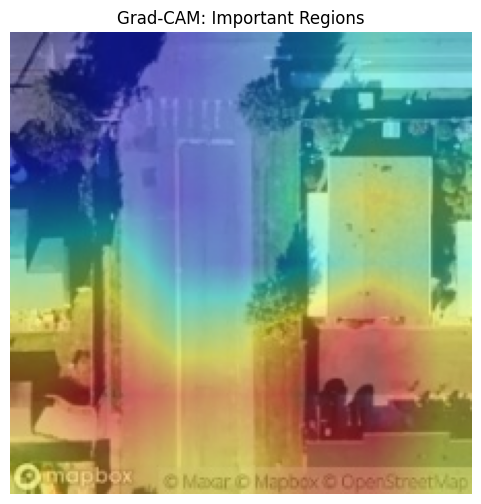

In [34]:
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM: Important Regions")
plt.show()


In [35]:
def generate_gradcam(img_path, model, target_layer):
    global gradients, activations

    gradients = None
    activations = None

    img_tensor = load_image(img_path).unsqueeze(0)
    img_tensor.requires_grad = True

    output = model(img_tensor)
    score = output.max()

    model.zero_grad()
    score.backward()

    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1)

    cam = torch.relu(cam)
    cam = cam.squeeze().detach().numpy()

    cam = cv2.resize(cam, (224, 224))
    cam = cam - cam.min()
    cam = cam / cam.max()

    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    return overlay


In [36]:
def generate_gradcam(img_path, model, target_layer):
    global gradients, activations

    gradients = None
    activations = None

    img_tensor = load_image(img_path).unsqueeze(0)
    img_tensor.requires_grad = True

    output = model(img_tensor)
    score = output.max()

    model.zero_grad()
    score.backward()

    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1)

    cam = torch.relu(cam)
    cam = cam.squeeze().detach().numpy()

    cam = cv2.resize(cam, (224, 224))
    cam = cam - cam.min()
    cam = cam / cam.max()

    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    return overlay


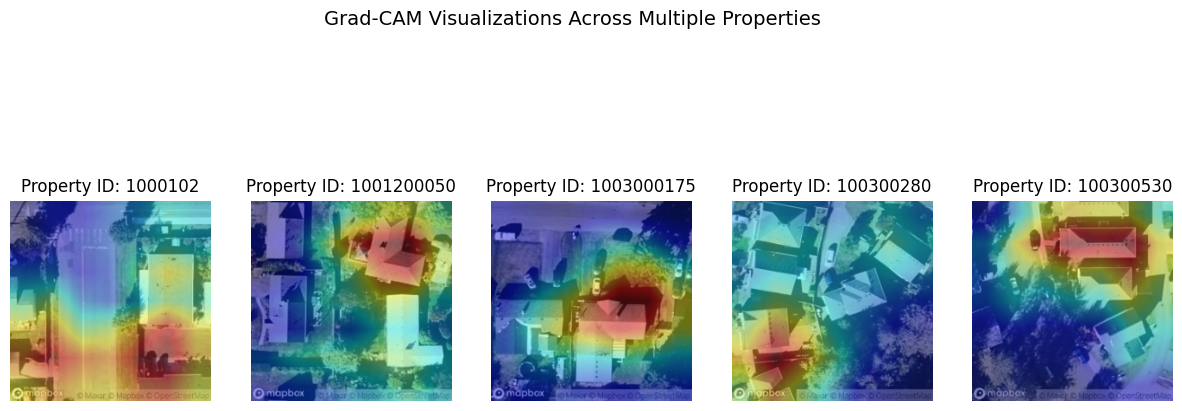

In [37]:
image_dir = "../notebooks/images/raw"
sample_images = os.listdir(image_dir)[:5]

plt.figure(figsize=(15, 6))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_dir, img_name)
    cam_overlay = generate_gradcam(img_path, resnet, target_layer)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(cam_overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Property ID: {img_name.replace('.png','')}")
    plt.axis("off")

plt.suptitle("Grad-CAM Visualizations Across Multiple Properties", fontsize=14)
plt.show()


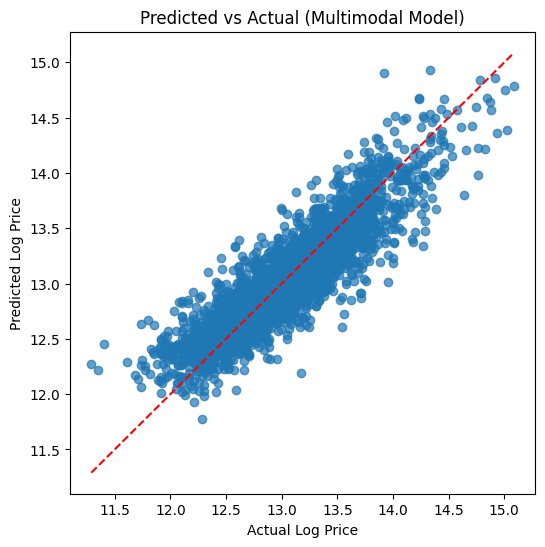

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_multi, alpha=0.7)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Predicted vs Actual (Multimodal Model)")
plt.show()


In [39]:
results_df = pd.DataFrame({
    "Actual_Log_Price": y_val.values,
    "Predicted_Log_Price": y_pred_multi
})
results_df["Actual_Price"] = np.expm1(results_df["Actual_Log_Price"])
results_df["Predicted_Price"] = np.expm1(results_df["Predicted_Log_Price"])
results_df["Absolute_Error"] = abs(
    results_df["Actual_Price"] - results_df["Predicted_Price"]
)

results_df.head(10)


,Actual_Log_Price,Predicted_Log_Price,Actual_Price,Predicted_Price,Absolute_Error
0,13.832369,13.318418,1017000.0,608295.612650,408704.387350
1,12.847798,13.102254,379950.0,490044.717948,110094.717948
2,14.047020,13.675491,1260500.0,869340.012289,391159.987711
3,13.180634,13.037580,530000.0,459354.833616,70645.166384
4,13.527763,13.130283,749950.0,503974.282211,245975.717789
5,12.736704,12.537174,340000.0,278499.141938,61500.858062
6,13.641158,13.526017,840000.0,748641.694972,91358.305028
7,13.091906,13.443009,485000.0,689007.328470,204007.328470
8,12.765691,12.640304,350000.0,308754.054038,41245.945962
9,12.807622,13.056909,364988.0,468319.910443,103331.910443


In [40]:
results_df["Percent_Error"] = (
    results_df["Absolute_Error"] / results_df["Actual_Price"]
) * 100

results_df["Percent_Error"].describe()


count    3039.000000
mean       18.699549
std        17.566230
min         0.000306
25%         6.795214
50%        14.466611
75%        25.062448
max       184.689798
Name: Percent_Error, dtype: float64